# Boom Bikes

In this note book we are going to predict the demand for bikes and how the demand is influenced by different factors.

**About Boom Bikes company**
A US Bike sharing company has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. BoomBikes want to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state.
Now BoomBikes want to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market.
**The company wants to know:**
- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands
The data used to predicit is based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors.

**Steps:**
1. Import data
2. EDA on imported data

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [21]:
bikesDF = pd.read_csv("day.csv", dtype={'dteday': 'str'})

#covert all date formats to same
bikesDF.dteday = bikesDF.dteday.str.replace('/','-')

#create a day column
bikesDF['day'] = (bikesDF.dteday.str[:2]).astype(int)

#convert date column to datetime
bikesDF['dteday'] = pd.to_datetime(bikesDF['dteday'], dayfirst=True)


# Monday:0, Tuesday:1, Wednesday:2, Thursday:3, Friday:4, Saturday:5, Sunday:6
weekends = [5,6]
weekdays = [0,1,2,3,4]
bikesDF['weekday'] = bikesDF['dteday'].dt.day_of_week

#convert date to YYYYMMDD format
bikesDF['dteday'] = bikesDF['dteday'].dt.strftime('%Y%m%d').astype(int)


print("Weekend being Monday and Tuesday count:", bikesDF[(bikesDF.weekday.isin(weekends)) | (bikesDF.workingday == 0)]['workingday'].count())

# In the data provided Weekends are Monday and Tuesday
#working days avg cnt = 4590.332665330661
#non-working days avg cnt = 4330.168831168831


# Weekends are Saturday and Sunday
#working days avg cnt = 4472.1984126984125
#non-working days avg cnt  = 4587.862831858407
# corrected the data to have weekends as Saturday and Sunday
bikesDF.loc[(bikesDF.weekday.isin(weekdays)) & (bikesDF.holiday == 0), 'workingday'] = 1
bikesDF.loc[(bikesDF.weekday.isin(weekends)) | (bikesDF.holiday == 1), 'workingday'] = 0

print("cnt is actually equal to casual plus registered: ",(bikesDF["cnt"] == (bikesDF["casual"]+bikesDF["registered"])))



print(bikesDF.head(100))
print(bikesDF.describe())


Weekend being Monday and Tuesday count: 392
cnt is actually equal to casual plus registered:  0      True
1      True
2      True
3      True
4      True
       ... 
725    True
726    True
727    True
728    True
729    True
Length: 730, dtype: bool
    instant    dteday  season  yr  mnth  holiday  weekday  workingday  \
0         1  20180101       1   0     1        0        0           1   
1         2  20180102       1   0     1        0        1           1   
2         3  20180103       1   0     1        0        2           1   
3         4  20180104       1   0     1        0        3           1   
4         5  20180105       1   0     1        0        4           1   
..      ...       ...     ...  ..   ...      ...      ...         ...   
95       96  20180406       2   0     4        0        4           1   
96       97  20180407       2   0     4        0        5           0   
97       98  20180408       2   0     4        0        6           0   
98       99  201804

             instant    dteday        season            yr          mnth  \
instant     1.000000  0.898332  4.135867e-01  8.660262e-01  4.982507e-01   
dteday      0.898332  1.000000  5.717295e-02  9.976279e-01  6.881433e-02   
season      0.413587  0.057173  1.000000e+00 -3.279074e-16  8.310321e-01   
yr          0.866026  0.997628 -3.279074e-16  1.000000e+00 -5.162656e-16   
mnth        0.498251  0.068814  8.310321e-01 -5.162656e-16  1.000000e+00   
holiday     0.016275  0.009458 -1.086804e-02  8.195345e-03  1.890483e-02   
weekday     0.003548  0.001099  3.042009e-04  6.843499e-04  6.079650e-03   
workingday -0.015171 -0.012526  1.786841e-02 -1.185197e-02 -1.041372e-02   
weathersit -0.021862 -0.047111  2.130636e-02 -5.032247e-02  4.561335e-02   
temp        0.150738  0.063791  3.333607e-01  4.878919e-02  2.190833e-01   
atemp       0.152773  0.062715  3.420139e-01  4.721519e-02  2.264302e-01   
hum         0.016080 -0.096735  2.082196e-01 -1.125471e-01  2.249368e-01   
windspeed  -

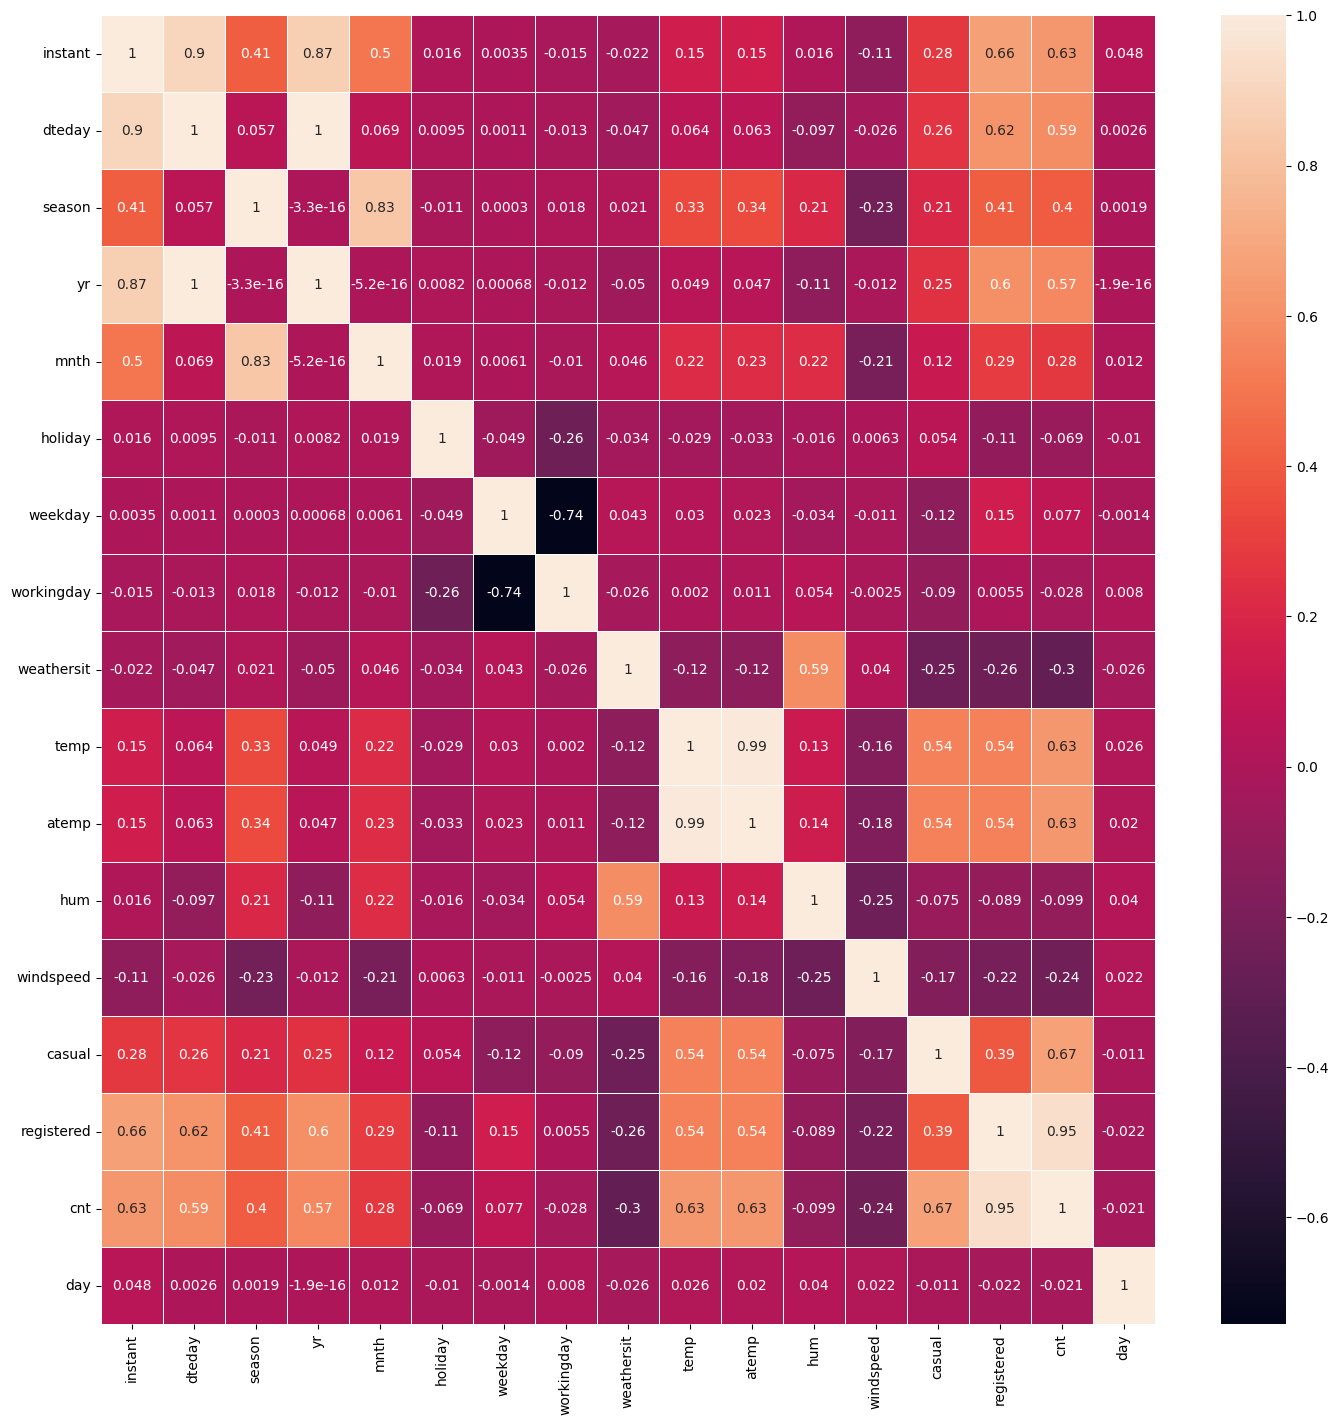

In [22]:
#lighter color is high correlation
print(bikesDF.corr())
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(bikesDF.corr(), annot=True, linewidths=.6, ax=ax)
plt.show()

# there is a high corelation between temp & atemp and month & season
# going to drop instant, dteday, atemp, 'casual'
bikesDF.drop(columns=['dteday','instant','atemp', 'casual', 'registered'], axis=1, inplace=True)

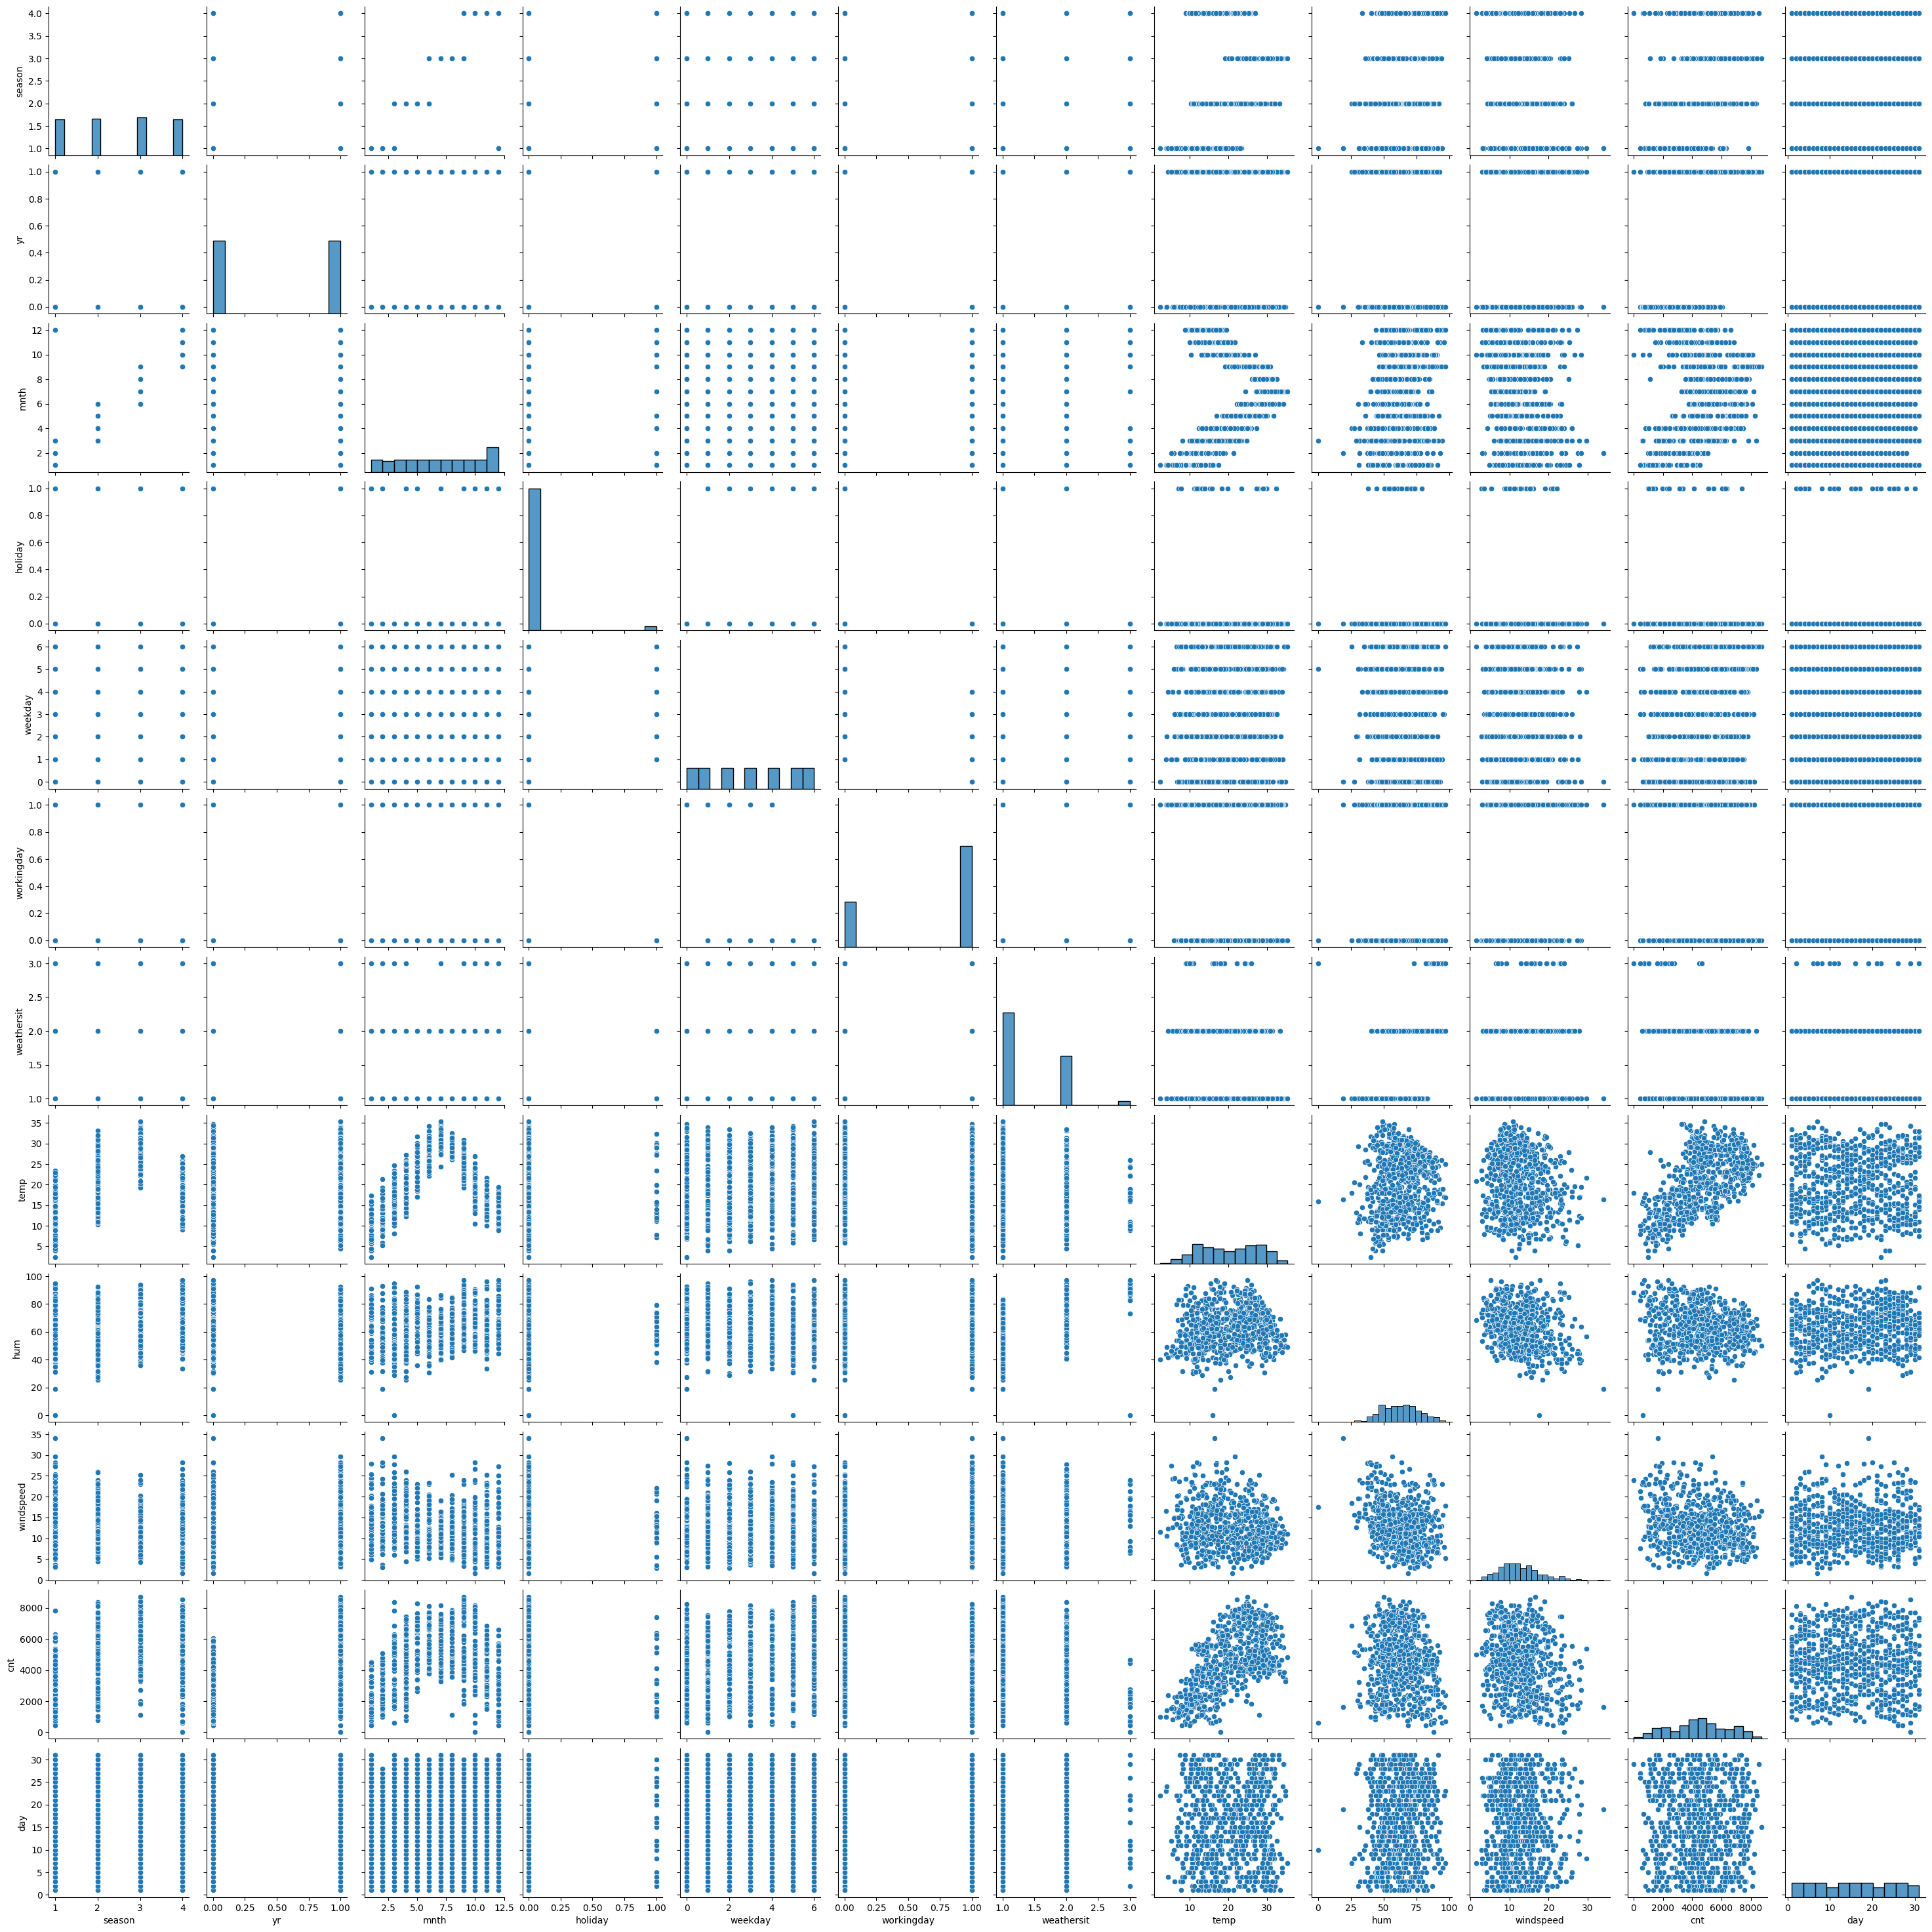

In [23]:
sns.pairplot(bikesDF)
plt.show()

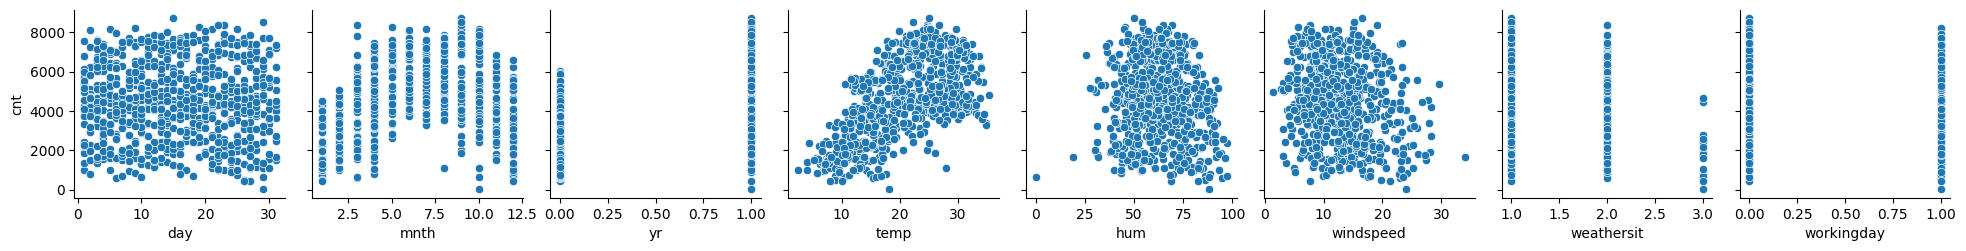

In [24]:
sns.pairplot(x_vars=["day","mnth","yr", "temp", "hum", "windspeed", "weathersit", "workingday"], y_vars="cnt", data=bikesDF)

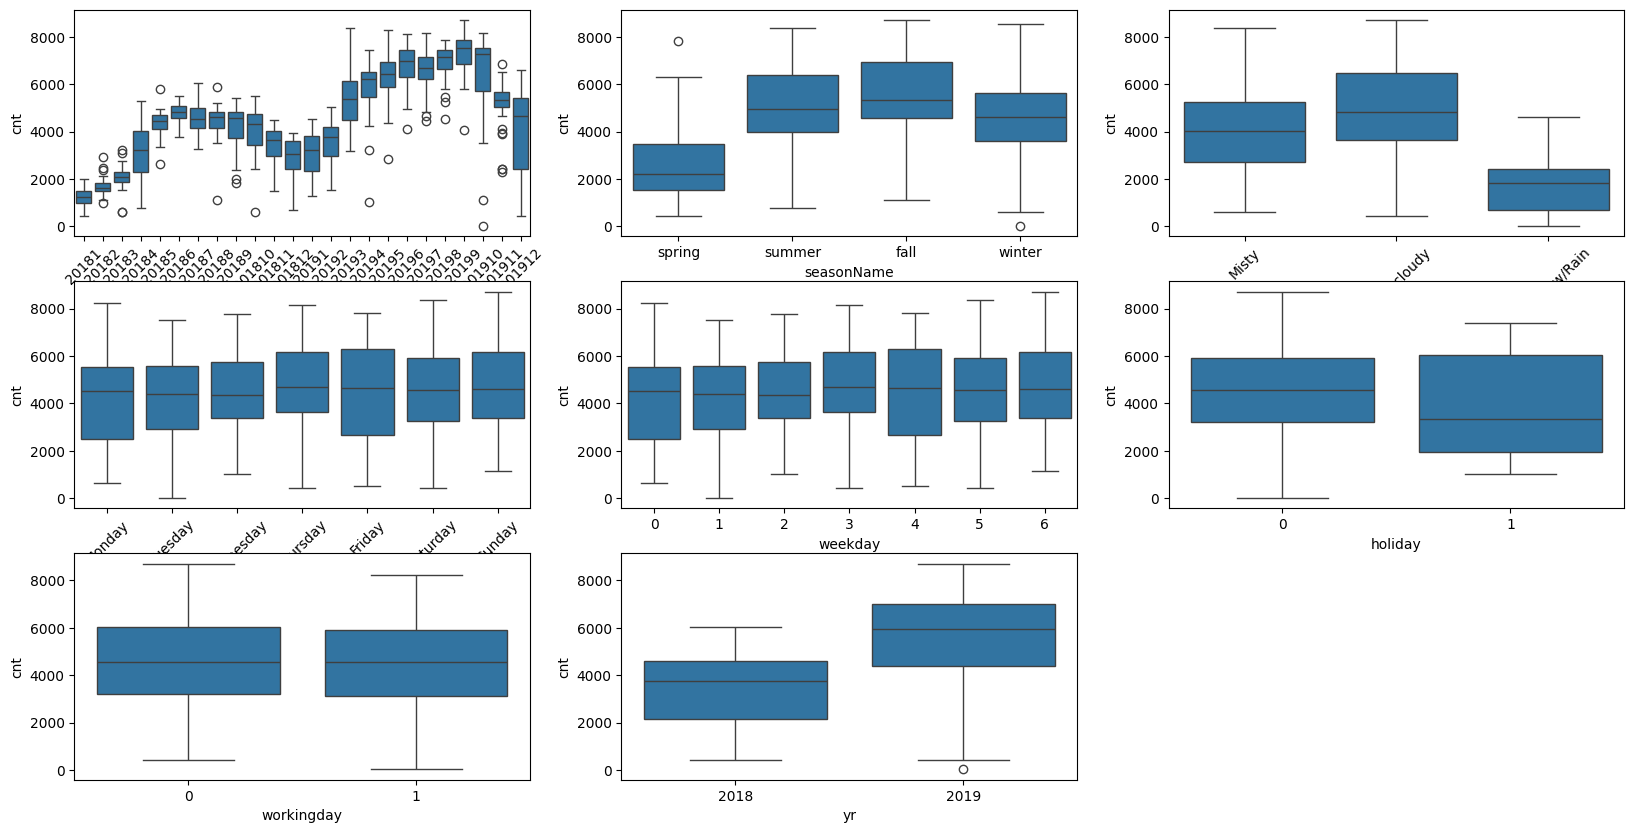

In [25]:

days_dict= {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
bikesDF['weekdayName'] = bikesDF['weekday'].map(days_dict)

bikesDF["non-corona-period"] = bikesDF["yr"]
year_dict = {0: 2018, 1: 2019}
bikesDF["yr"] = bikesDF["yr"].map(year_dict)

season_dict = {1:"spring", 2:"summer", 3:"fall", 4:"winter"}
bikesDF["seasonName"] = bikesDF["season"].map(season_dict)


weather_dict = {1:"Partly cloudy", 2:"Misty", 3:"Light Snow/Rain"}
bikesDF["weatherLike"] = bikesDF["weathersit"].map(weather_dict)


#visualize categorical variables
plt.figure(figsize=(20,10))

bikesDF["yyyyMM"] = bikesDF["yr"].astype(str) + bikesDF["mnth"].astype(str)

plt.subplot(3,3,1)
ax=sns.boxplot(x="yyyyMM", y="cnt", data=bikesDF)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


plt.subplot(3,3,2)
sns.boxplot(x="seasonName", y="cnt", data=bikesDF)

plt.subplot(3,3,3)
ax=sns.boxplot(x="weatherLike", y="cnt", data=bikesDF)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.subplot(3,3,4)
ax=sns.boxplot(x="weekdayName", y="cnt", data=bikesDF)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


plt.subplot(3,3,5)
sns.boxplot(x="weekday", y="cnt", data=bikesDF)


plt.subplot(3,3,6)
sns.boxplot(x="holiday", y="cnt", data=bikesDF)


plt.subplot(3,3,7)
sns.boxplot(x="workingday", y="cnt", data=bikesDF)

plt.subplot(3,3,8)
sns.boxplot(x="yr", y="cnt", data=bikesDF)

plt.show()

In [26]:
# from the graph we don't see there is much change in workingday and weekdayName
bikesDF.drop(columns=['workingday', 'holiday','weekday','hum', 'yr', 'day','mnth','yyyyMM','weekdayName'], axis=1, inplace=True)

#weekdays = pd.get_dummies(bikesDF['weekdayName'], dtype=int, drop_first=True)
seasons = pd.get_dummies(bikesDF['seasonName'], dtype=int, drop_first=True)
#weatherLike = pd.get_dummies(bikesDF['weatherLike'], dtype=int, drop_first=True)

bikesDF = pd.concat([bikesDF,seasons], axis=1)

bikesDF.drop(columns=['seasonName','season', 'weathersit', 'weatherLike'], axis=1, inplace=True)

bikesDF.head()

,temp,windspeed,cnt,non-corona-period,spring,summer,winter
0,14.110847,10.749882,985,0,1,0,0
1,14.902598,16.652113,801,0,1,0,0
2,8.050924,16.636703,1349,0,1,0,0
3,8.200000,10.739832,1562,0,1,0,0
4,9.305237,12.522300,1600,0,1,0,0


In [28]:
# Create training set and test set 70 - 30 %
bikesDF_train, bikesDF_test = train_test_split(bikesDF, train_size=0.70, test_size=0.30, random_state=100)

#scale training data

# instatiate object
scaler = MinMaxScaler()

num_vars = ['temp','windspeed','cnt']


# fit on data
bikesDF_train[num_vars] = scaler.fit_transform(bikesDF_train[num_vars])

bikesDF_train.head()

,temp,windspeed,cnt,non-corona-period,spring,summer,winter
653,0.509887,0.300794,0.864243,1,0,0,1
576,0.815169,0.264686,0.827658,1,0,0,0
426,0.442393,0.255342,0.465255,1,1,0,0
728,0.245101,0.663106,0.204096,1,1,0,0
482,0.395666,0.188475,0.482973,1,0,1,0


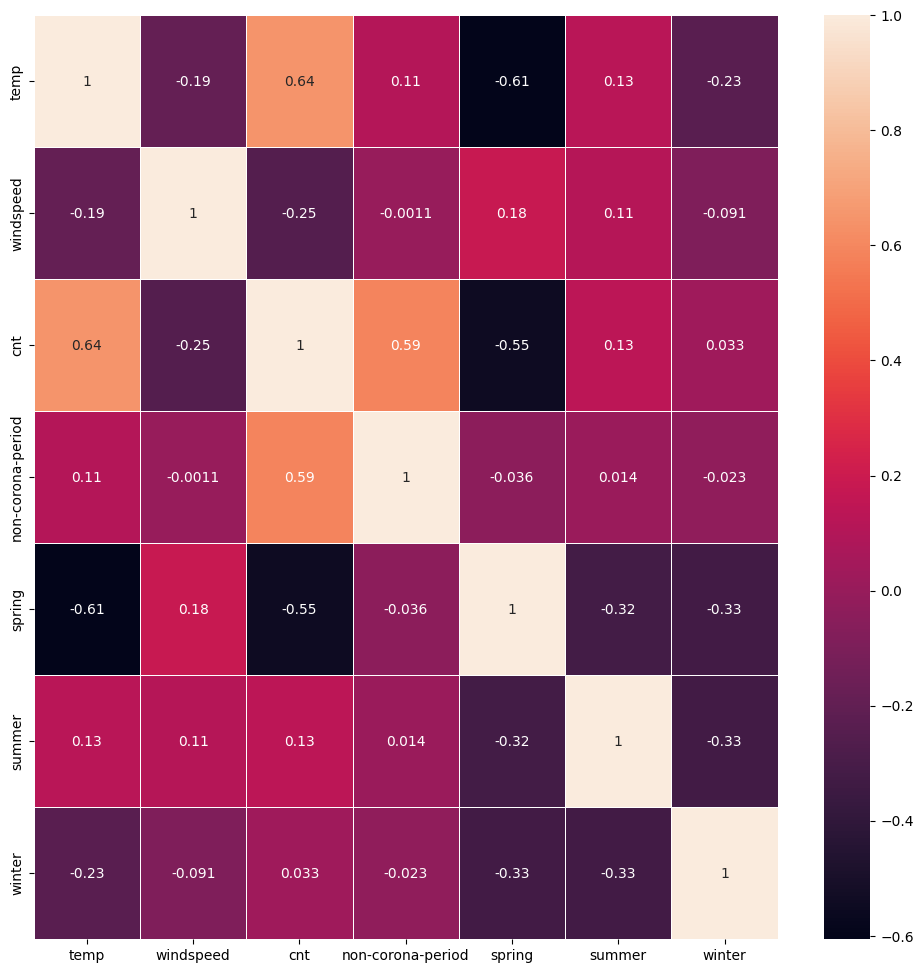

In [29]:
#train the model

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(bikesDF_train.corr(), annot=True, linewidths=.6, ax=ax)
plt.show()

In [30]:
y_train = bikesDF_train.pop("cnt")
X_train = bikesDF_train

# build with all variables
X_train_sm = sm.add_constant(X_train)

# fitting the model
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()

# gives coefficient of const(intercept)
#print(lr_model.params)

print(lr_model.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     266.3
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          1.37e-152
Time:                        06:23:18   Log-Likelihood:                 403.02
No. Observations:                 510   AIC:                            -792.0
Df Residuals:                     503   BIC:                            -762.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1683      0.03

In [31]:
#VIF

#create a dataframe containing all the feature names and the respective
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
1,windspeed,4.53
0,temp,3.42
2,non-corona-period,2.06
3,spring,1.87
4,summer,1.74
5,winter,1.53


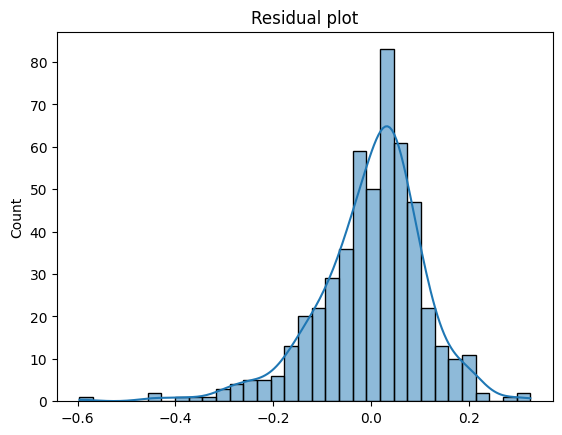

In [32]:
y_train_pred = lr_model.predict(X_train_sm)

# Residual analysis
#error = f(y_train, y_train_pred)
res = y_train - y_train_pred

#plot residuals
plt.figure()
sns.histplot(res, kde=True)
plt.title("Residual plot")
plt.show()


In [33]:
#scale test data
num_vars = ['temp','windspeed','cnt']


# fit on data
bikesDF_test[num_vars] = scaler.transform(bikesDF_test[num_vars])

bikesDF_test.head()
bikesDF_test.describe()

,temp,windspeed,cnt,non-corona-period,spring,summer,winter
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.558941,0.313350,0.520592,0.479452,0.255708,0.264840,0.232877
std,0.233698,0.159947,0.218435,0.500722,0.437258,0.442259,0.423633
min,0.046591,-0.042808,0.048205,0.000000,0.000000,0.000000,0.000000
25%,0.354650,0.198517,0.377531,0.000000,0.000000,0.000000,0.000000
50%,0.558691,0.299459,0.524275,0.000000,0.000000,0.000000,0.000000
75%,0.759096,0.403048,0.672745,1.000000,1.000000,1.000000,0.000000
max,0.984424,0.807474,0.963300,1.000000,1.000000,1.000000,1.000000


In [34]:
y_test = bikesDF_test.pop('cnt')
X_test = bikesDF_test

# build with all variables
X_test_sm = sm.add_constant(X_test)

#predict on test
y_test_pred = lr_model.predict(X_test_sm)

# evaluate the model, R-squared on the test set
r2 = r2_score(y_true=y_test,y_pred=y_test_pred)

print("R2 value on test data is:", r2)

#r2 on train
r2 = r2_score(y_true=y_train,y_pred=y_train_pred)
print("R2 value on training data is:", r2)

R2 value on test data is: 0.7563004699716726
R2 value on training data is: 0.7605587261047397


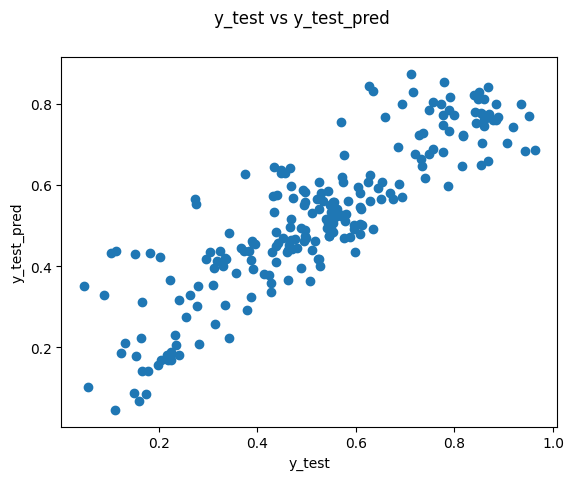

In [35]:
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred')
plt.xlabel("y_test")
plt.ylabel("y_test_pred")
plt.show()